# MODELING

Because of the nature of our problem and looking at the data, the models that are likely to work best are xgboost, light lbm and lstm.
**Both models are variants of Gradient Boosting and can handle data with many explanatory variables (features). They are also effective with lag features and window statistics, and tend to be robust to noisy data.

**LSTM:** Ideal for time series with long and non-linear dependencies. Works well when features include lags and windowing.

 AFTER THE TESTS WE HAVE CARRIED OUT, WE HAVE TWO OPTIONS WHICH SEEM VIABLE. FIRST, WE HAVE XGBOOST WHICH FITS WELL AND WE GET GOOD METRICS. ON THE OTHER HAND, WE HAVE LSTM, WHICH GETS SOME METRICS BETTER AND SOME WORSE, BUT WHEN IT COMES TO GENERALIZING IT SEEMS TO FIT BETTER. SO WE ARE GOING TO PUT SEVERAL CONCLUSIONS.

**-METRICS:** BOTH METRICS ARE GOOD AND SIMILAR. SO THEY ARE NOT GOING TO BE A DETERMINING FACTOR.

**-LSTM:** WE LIKE MORE THE GENERALIZATION IT MAKES OF THE DATA IN THE TEST SET. PROBLEM: IT REQUIRES A HIGH COMPUTATIONAL COST. IT TAKES A LONG TIME TO TRAIN THIS MODEL, SO IT CAN BE A LOT OF WORK TO OPTIMIZE, EVEN THOUGH WITH LSTM, IT DOES NOT REQUIRE A LOT OF STRUCTURAL WORK.


**- XGBOOST:** WE LIKE IT LESS AS IT GENERALIZES, BUT THE COMPUTATIONAL COST IS MUCH LOWER. SO IT IS WORTH TRYING TO OPTIMIZE IT IN THE FIRST PLACE.





**CONCLUSION**.
Let's first work with xgboost and depending on the results we will make one decision or another. Since the computational cost and time it may take us to optimize the models is also something to take into account.


# IMPORTS

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd

from xgboost import XGBRegressor
import warnings
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

import optuna
import os
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

In [ ]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

# Función para RMSSE (Métrica personalizada para series temporales)
def rmsse(y_true, y_pred):
    naive_error = y_true.diff().dropna() ** 2
    scaled_error = ((y_true - y_pred) ** 2).sum() / naive_error.sum()
    return (scaled_error ** 0.5)


def accuracy_within_threshold(y_true, y_pred, threshold=0.05):
    within_threshold = abs(y_true - y_pred) <= threshold * y_true
    return within_threshold.mean() * 100  # Porcentaje de aciertos dentro del umbral

In [ ]:
def calculate_lags_and_means(df, day):
    lags = [1, 2, 3, 4, 5, 6, 7, 10, 12, 15]
    df_lag = df[(df['d'] <= day) & (df['d'] >= day - max(lags))].copy()

    for lag in lags:
        df_lag['sold_lag_' + str(lag)] = (
            df_lag.groupby(['item_id', 'dept_id', 'cat_id'], as_index=False)['sold']
            .shift(lag).astype(np.float16)
        )
        # Asegura la alineación de índices entre df y df_lag antes de asignar
        df.loc[df['d'] == day, 'sold_lag_' + str(lag)] = df_lag.loc[df_lag['d'] == day, 'sold_lag_' + str(lag)].values

    # Calcular medias rodantes y expansivas
    df_means = df[(df['d'] <= day) & (df['d'] >= day - 28)].copy()
    df_means['rolling_sold_mean'] = (
        df_means.groupby(['item_id', 'dept_id', 'cat_id'])['sold']
        .transform(lambda x: x.rolling(window=7, min_periods=1).mean()).astype(np.float16)
    )

    df_means['rolling_sold_mean_14'] = (
        df_means.groupby(['item_id', 'dept_id', 'cat_id'])['sold']
        .transform(lambda x: x.rolling(window=14, min_periods=1).mean()).astype(np.float16)
    )

    df_means['rolling_sold_mean_28'] = (
        df_means.groupby(['item_id', 'dept_id', 'cat_id'])['sold']
        .transform(lambda x: x.rolling(window=28, min_periods=1).mean()).astype(np.float16)
    )

    df_means['expanding_sold_mean'] = (
        df_means.groupby(['item_id', 'dept_id', 'cat_id'])['sold']
        .transform(lambda x: x.expanding(2).mean()).astype(np.float16)
    )

    # Realiza las asignaciones asegurando que las dimensiones coincidan
    for col in ["rolling_sold_mean", "rolling_sold_mean_14", "rolling_sold_mean_28", "expanding_sold_mean"]:
        df.loc[df['d'] == day, col] = df_means.loc[df_means['d'] == day, col].reindex(df[df['d'] == day].index).values

    return df

In [ ]:
# Necesitamos darle la duración para hacer las predicciones:
def predictions(df, duration,model, day_1):

    # Guarda las ventas reales en una nueva columna antes de sobrescribir 'sold' con predicciones
    if 'sold_reales' not in df.columns:
        df['sold_reales'] = df['sold']


    for day in range(day_1, day_1+duration+1):
        df = calculate_lags_and_means(df, day)
        X_day = df[df['d'] == day].drop(columns=['sold', "pred_sales","sold_reales"], errors='ignore')
        predictions = model.predict(X_day)
        predictions = np.round(predictions)
        df.loc[df['d'] == day, 'sold'] = predictions
    return df

# XGBOOST

## LOOKING FOR HIPER-PARAMETERS

Aplicaremos RandomizedSearch junto con Rolling-Cross-Validation

In [ ]:
df_train = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/train.pkl")
df_val = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/validation.pkl")

In [ ]:
df_train.drop(["date"], axis=1, inplace=True)
df_val.drop(["date"], axis=1, inplace=True)

In [ ]:
X_train, y_train = df_train.drop(columns=['sold']), df_train['sold']
X_val, y_val = df_val.drop(columns=['sold']), df_val['sold']

In [ ]:
# Concatenar conjuntos de entrenamiento y validación para usar TimeSeriesSplit
X = pd.concat([X_train, X_val], axis=0)
y = pd.concat([y_train, y_val], axis=0)

In [ ]:
# Definir el esquema de TimeSeriesSplit con un mayor número de splits
start_time = time.time()
tscv = TimeSeriesSplit(n_splits=10)  # Ajusta si es necesario

# Función objetivo para Optuna con el nuevo espacio de hiperparámetros
def objective(trial):
    # Definir el espacio de búsqueda de Optuna
    param = {
        'max_depth': trial.suggest_int('max_depth', 6, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'objective': 'reg:squarederror'
    }

    # Evaluación con Rolling Cross-Validation
    rmse_list = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = xgb.XGBRegressor(**param,early_stopping_rounds=50)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],  # Para detener el entrenamiento si no mejora
                  verbose=False)

        y_val_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_val_pred, squared=False)
        rmse_list.append(rmse)

    # Retornar el promedio del RMSE en todas las folds
    return sum(rmse_list) / len(rmse_list)

end_time = time.time()
training_time = end_time - start_time
# Ejecutar la optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Ajusta n_trials si es necesario

# Mostrar los mejores hiperparámetros
print("Mejores Hiperparámetros:", study.best_params)
print("Mejor RMSE:", study.best_value)


[I 2024-11-13 17:43:51,081] A new study created in memory with name: no-name-189dd441-17b5-4e45-b93d-c3b5f97c4b7e
[I 2024-11-13 17:53:15,783] Trial 0 finished with value: 2.241202187538147 and parameters: {'max_depth': 10, 'learning_rate': 0.09013431508297587, 'n_estimators': 340, 'subsample': 0.6294484825599347, 'colsample_bytree': 0.8417007774333103}. Best is trial 0 with value: 2.241202187538147.
[I 2024-11-13 18:13:46,900] Trial 1 finished with value: 2.3555146932601927 and parameters: {'max_depth': 14, 'learning_rate': 0.05714743305843624, 'n_estimators': 395, 'subsample': 0.7223820757964261, 'colsample_bytree': 0.7041420987165016}. Best is trial 0 with value: 2.241202187538147.
[I 2024-11-13 18:23:31,048] Trial 2 finished with value: 2.371974503993988 and parameters: {'max_depth': 11, 'learning_rate': 0.025652765734770676, 'n_estimators': 238, 'subsample': 0.7650256666702382, 'colsample_bytree': 0.8668954911327639}. Best is trial 0 with value: 2.241202187538147.
[I 2024-11-13 18:

Mejores Hiperparámetros: {'max_depth': 6, 'learning_rate': 0.06980137651767652, 'n_estimators': 996, 'subsample': 0.9426712060212157, 'colsample_bytree': 0.7912354443375331}
Mejor RMSE: 2.082551896572113


AttributeError: 'Study' object has no attribute 'best_rmse'

In [ ]:
params_path = "/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/models/best_xgboost_params.json"
os.makedirs(os.path.dirname(params_path), exist_ok=True)

with open(params_path, "w") as f:
    json.dump({"best_params": study.best_params, "best_rmse": study.best_value}, f)

NameError: name 'study' is not defined

## TRAINING A MODEL WITH THAT PARAMETERS TO SEE METRICS

We are going to train now a  model with those hiper-parameters, but with train and lost. In this way we'll be able to see metrics.

### train

First of all we have to separte the set in train-validation-test-new(data)

In [ ]:
df_train = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/train.pkl")
df_val = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/validation.pkl")

In [ ]:
df_new = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/test.pkl")

In [ ]:
df_full = pd.concat([df_train, df_val], ignore_index=True).sort_values(by='d').reset_index(drop=True).drop(columns=['date'])

In [ ]:
ultimo_dia = 1941

# Definir los rangos para test y validation basados en el valor de la columna 'd'
dia_inicio_test = ultimo_dia - 15 + 1  # Desde 1927 hasta 1941 para test (15 días)
dia_inicio_validation = ultimo_dia - 15 - 15 + 1  # Desde 1912 hasta 1926 para validation (15 días)

# Crear los conjuntos de datos usando filtros en la columna 'd'
df_test = df_full[df_full['d'] >= dia_inicio_test]  # Últimos 15 días para test
df_validation = df_full[(df_full['d'] >= dia_inicio_validation) & (df_full['d'] < dia_inicio_test)]  # 15 días anteriores para validation
df_train = df_full[df_full['d'] < dia_inicio_validation]  # Resto de los datos para train

# Verificar la separación
print("Tamaño del conjunto de entrenamiento:", df_train.shape)
print("Tamaño del conjunto de validación:", df_validation.shape)
print("Tamaño del conjunto de prueba:", df_test.shape)

Tamaño del conjunto de entrenamiento: (5780904, 36)
Tamaño del conjunto de validación: (45735, 36)
Tamaño del conjunto de prueba: (45735, 36)


In [ ]:
X_train, y_train = df_train.drop(columns=['sold']), df_train['sold']
X_val, y_val = df_validation.drop(columns=['sold']), df_validation['sold']

In [ ]:
# Configuración del modelo XGBoost con los mejores hiperparámetros
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # Tipo de error cuadrado para regresión
    max_depth=6,                   # Profundidad máxima del árbol
    learning_rate=0.06980137651767652,  # Tasa de aprendizaje
    n_estimators=996,              # Número de árboles
    subsample=0.9426712060212157,  # Porcentaje de muestras utilizadas en cada árbol
    colsample_bytree=0.7912354443375331  # Porcentaje de características por árbol
)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7912354443375331, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.06980137651767652, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=996, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Guardar el modelo en un archivo .json (formato de XGBoost)
xgb_model.save_model('/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/models/xgb_1.json')

### validation (daily metrics)

We get good metrics making predictions daily.

In [ ]:
xgb_model = XGBRegressor()
xgb_model.load_model('/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/models/xgb_1.json')

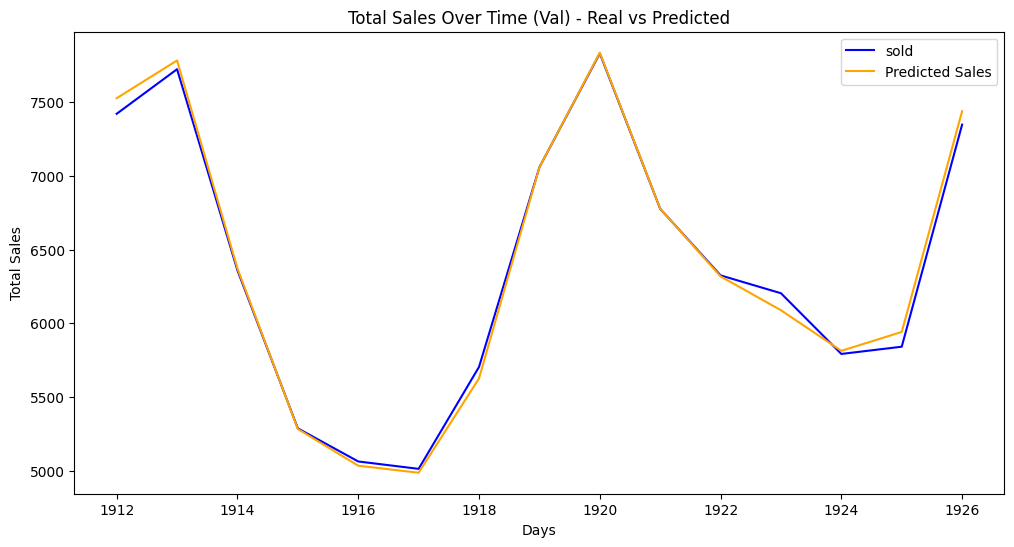

In [ ]:
y_pred_val = xgb_model.predict(X_val)

df_validation["pred_sales"] = y_pred_val

sum_sales_by_day_val = df_validation.groupby('d')[['sold', 'pred_sales']].sum()

# Gráfica de la sumatoria de ventas diaria (Predicciones vs Reales) en el conjunto de validación
plt.figure(figsize=(12, 6))
plt.plot(sum_sales_by_day_val.index, sum_sales_by_day_val['sold'], label='sold', color='blue')
plt.plot(sum_sales_by_day_val.index, sum_sales_by_day_val['pred_sales'], label='Predicted Sales', color='orange')
plt.xlabel('Days')
plt.ylabel('Total Sales')
plt.title('Total Sales Over Time (Val) - Real vs Predicted')
plt.legend()
plt.show()

In [ ]:
# Evaluación en el conjunto de prueba
rmse_test = rmse(y_val, y_pred_val)
mae_test = mean_absolute_error(y_val, y_pred_val)
rmsse_test = rmsse(y_val, y_pred_val)




# Resultados
print(f"RMSE - Test: {rmse_test:.4f}")
print(f"MAE - Test: {mae_test:.4f}")
print(f"RMSSE - Test: {rmsse_test:.4f}")

RMSE - Test: 0.9494
MAE - Test: 0.2390
RMSSE - Test: 0.1406


### validation (recursive metrics)

We need to see the metrics doing recursive predictions

In [ ]:
df_combined = pd.concat([df_train, df_validation], ignore_index=True)

df_combined = df_combined.sort_values(by='d', ascending=True)

In [ ]:
pd.set_option('display.max_columns', None)
df_combined.tail()

,item_id,dept_id,cat_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,item_sold_avg,cat_sold_avg,dept_sold_avg,cat_dept_sold_avg,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_4,sold_lag_5,sold_lag_6,sold_lag_7,sold_lag_10,sold_lag_12,sold_lag_15,rolling_sold_mean,rolling_sold_mean_14,rolling_sold_mean_28,expanding_sold_mean,pred_sales
5824609,1435,2,0,1926,0,11616.0,2,1.0,5.0,2016.0,-1,-1,-1,-1,1.0,1.0,0.0,1.280273,0.609863,2.599609,3.365234,3.365234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.646484,0.002884
5824610,1426,2,0,1926,2,11616.0,2,1.0,5.0,2016.0,-1,-1,-1,-1,1.0,1.0,0.0,2.939453,0.918457,2.599609,3.365234,3.365234,0.0,0.0,0.0,1.0,0.0,2.0,4.0,0.0,2.0,0.0,0.714355,0.714355,0.714355,0.968750,1.816949
5824611,1344,2,0,1926,4,11616.0,2,1.0,5.0,2016.0,-1,-1,-1,-1,1.0,1.0,0.0,1.780273,9.171875,2.599609,3.365234,3.365234,15.0,3.0,9.0,11.0,3.0,8.0,4.0,5.0,7.0,4.0,7.570312,7.570312,7.570312,9.664062,4.074906
5824602,1428,2,0,1926,6,11616.0,2,1.0,5.0,2016.0,-1,-1,-1,-1,1.0,1.0,0.0,1.980469,3.398438,2.599609,3.365234,3.365234,2.0,0.0,7.0,0.0,1.0,6.0,0.0,2.0,2.0,0.0,3.142578,3.142578,3.142578,3.591797,5.894599
5826638,2454,5,2,1926,17,11616.0,2,1.0,5.0,2016.0,-1,-1,-1,-1,1.0,1.0,0.0,2.359375,5.746094,1.291992,2.013672,2.013672,6.0,2.0,26.0,0.0,1.0,0.0,24.0,9.0,14.0,3.0,7.429688,7.429688,7.429688,6.007812,16.420214


In [ ]:
df_combined= predictions(df_combined, 15, xgb_model, 1912)

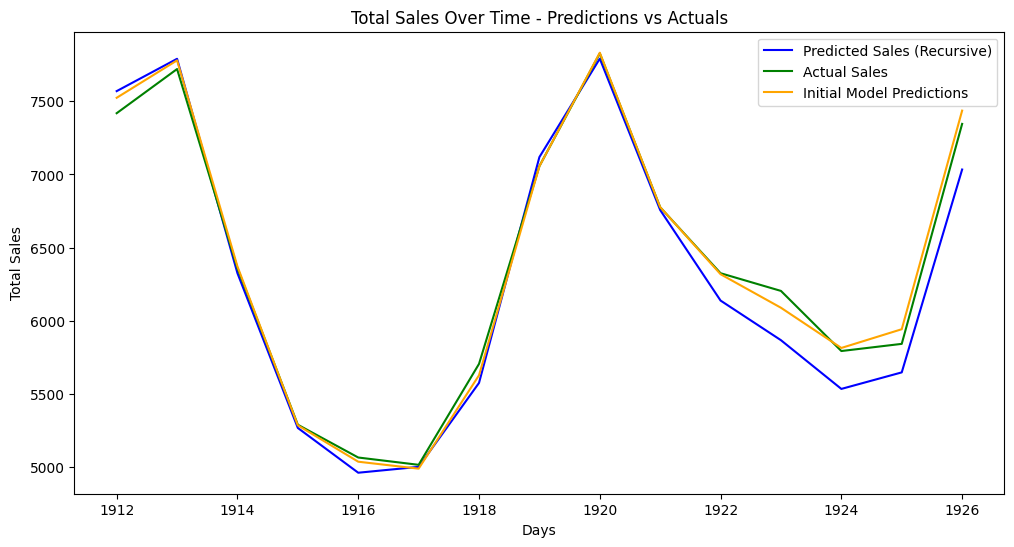

In [ ]:
# Filtrar solo los días entre 1912 y 1912 + 15
df_plot = df_combined[(df_combined['d'] >= 1912) & (df_combined['d'] <= 1912 + 15)]

# Calcular la sumatoria diaria de ventas (predicciones y reales)
sum_sales_by_day = df_plot.groupby('d')[['sold', 'sold_reales', 'pred_sales']].sum()

# Crear la gráfica
plt.figure(figsize=(12, 6))
plt.plot(sum_sales_by_day.index, sum_sales_by_day['sold'], label='Predicted Sales (Recursive)', color='blue')
plt.plot(sum_sales_by_day.index, sum_sales_by_day['sold_reales'], label='Actual Sales', color='green')
plt.plot(sum_sales_by_day.index, sum_sales_by_day['pred_sales'], label='Initial Model Predictions', color='orange')

# Configurar etiquetas y título
plt.xlabel('Days')
plt.ylabel('Total Sales')
plt.title('Total Sales Over Time - Predictions vs Actuals')
plt.legend()
plt.show()

In [ ]:
# Filtrar y agrupar los datos por día en el rango de 1912 a 1912 + 15
df_plot = df_combined[(df_combined['d'] >= 1912) & (df_combined['d'] <= 1912 + 15)]
sum_sales_by_day = df_plot.groupby('d')[['sold', 'sold_reales']].sum()

# Calcular las métricas usando sold_reales como verdadero y sold como predicción
y_true = df_plot['sold_reales']
y_pred = df_plot['sold']

# Calcular las métricas
rmse_test = rmse(y_true, y_pred)
mae_test = mean_absolute_error(y_true, y_pred)
rmsse_test = rmsse(y_true, y_pred)

# Resultados
print(f"RMSE - Val: {rmse_test:.4f}")
print(f"MAE - Val: {mae_test:.4f}")
print(f"RMSSE - Val: {rmsse_test:.4f}")

RMSE - Val: 1.3364
MAE - Val: 0.4251
RMSSE - Val: 0.1979


### metrics compare

We can see a better performance in daily predictions but it's not real. So in recursive metrics we have worst metrics but they are good enough

RMSE - Test: 0.9494
MAE - Test: 0.2390
RMSSE - Test: 0.1406

In [ ]:
metricas = {
    'Métrica': ['RMSE - Test', 'MAE - Test', 'RMSSE - Test', ],
    'Primer Modelo(Predicción diaria)': [1.1248, 0.4439, 0.1709],
    "Predicción diaria": [0.9494, 0.2390, 0.1406],
    'Predicción recursiva': [1.3364, 0.4251, 0.1979]
}

df_metricas = pd.DataFrame(metricas)

df_metricas

,Métrica,Primer Modelo(Predicción diaria),Predicción diaria,Predicción recursiva
0,RMSE - Test,1.1248,0.9494,1.3364
1,MAE - Test,0.4439,0.2390,0.4251
2,RMSSE - Test,0.1709,0.1406,0.1979


### test

Now we are satisfied with our model in validation set. We are going to see now how it works with new data.

In [ ]:
df_combined = pd.concat([df_train,df_validation, df_test], ignore_index=True)

df_combined = df_combined.sort_values(by='d', ascending=True)

In [ ]:
df_combined= predictions(df_combined, 15, xgb_model, 1926)

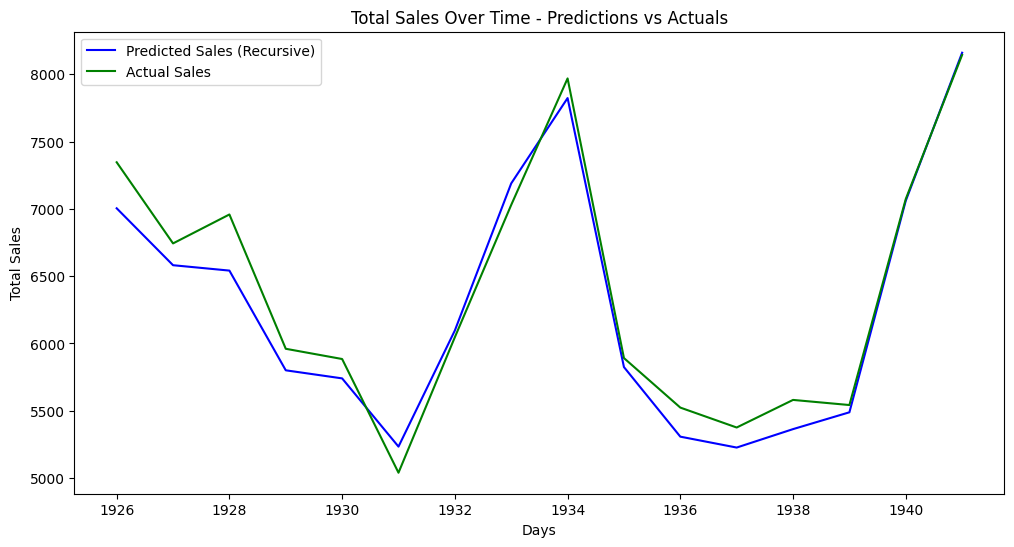

In [ ]:
# Filtrar solo los días entre 1926 y 1926 + 15
df_plot = df_combined[(df_combined['d'] >= 1926) & (df_combined['d'] <= 1926 + 15)]

# Calcular la sumatoria diaria de ventas (predicciones y reales)
sum_sales_by_day = df_plot.groupby('d')[['sold', 'sold_reales', 'pred_sales']].sum()

# Crear la gráfica
plt.figure(figsize=(12, 6))
plt.plot(sum_sales_by_day.index, sum_sales_by_day['sold'], label='Predicted Sales (Recursive)', color='blue')
plt.plot(sum_sales_by_day.index, sum_sales_by_day['sold_reales'], label='Actual Sales', color='green')

# Configurar etiquetas y título
plt.xlabel('Days')
plt.ylabel('Total Sales')
plt.title('Total Sales Over Time - Predictions vs Actuals')
plt.legend()
plt.show()

In [ ]:
# Filtrar y agrupar los datos por día en el rango de 1912 a 1912 + 15
df_plot = df_combined[(df_combined['d'] >= 1926) & (df_combined['d'] <= 1926 + 15)]
sum_sales_by_day = df_plot.groupby('d')[['sold', 'sold_reales']].sum()

# Calcular las métricas usando sold_reales como verdadero y sold como predicción
y_true = df_plot['sold_reales']
y_pred = df_plot['sold']

# Calcular las métricas
rmse_test = rmse(y_true, y_pred)
mae_test = mean_absolute_error(y_true, y_pred)
rmsse_test = rmsse(y_true, y_pred)

# Resultados
print(f"RMSE - Val: {rmse_test:.4f}")
print(f"MAE - Val: {mae_test:.4f}")
print(f"RMSSE - Val: {rmsse_test:.4f}")

RMSE - Val: 1.4630
MAE - Val: 0.4202
RMSSE - Val: 0.2158


# TRAINING THE LAST MODEL WITH THE WHOLE DATASET

Now, we are going to train the model with all our datasets. So we are not going to slipt in train-validation sets.

In [ ]:
df_train = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/train.pkl")
df_val = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/validation.pkl")

In [ ]:
df_train.drop(["date"], axis=1, inplace=True)
df_val.drop(["date"], axis=1, inplace=True)

X_train, y_train = df_train.drop(columns=['sold']), df_train['sold']
X_val, y_val = df_val.drop(columns=['sold']), df_val['sold']

In [ ]:
X = pd.concat([X_train, X_val], axis=0)
y = pd.concat([y_train, y_val], axis=0)

In [ ]:
# Configuración del modelo XGBoost con los mejores hiperparámetros
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # Tipo de error cuadrado para regresión
    max_depth=6,                   # Profundidad máxima del árbol
    learning_rate=0.06980137651767652,  # Tasa de aprendizaje
    n_estimators=996,              # Número de árboles
    subsample=0.9426712060212157,  # Porcentaje de muestras utilizadas en cada árbol
    colsample_bytree=0.7912354443375331  # Porcentaje de características por árbol
)

# Entrenar el modelo
xgb_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7912354443375331, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.06980137651767652, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=996, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## SAVE THE FINAL MODEL

In [ ]:
# Guardar el modelo en un archivo .json (formato de XGBoost)
xgb_model.save_model('/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/models/final_model.json')